# Biphenyl molecule simulation
We are looking for a solution for this variation of Shrodinger equation:
$$
\left[-\frac{\hbar^2}{2I}\frac{d^2}{d\phi^2} + V_0(\phi)\right] \psi_m(\phi) = E_m\psi_m(\phi)
$$
Where 
$$
V_0(\phi)=\frac{1}{2}\left[V_2(1-\cos{2\phi}) + V_4(1-\cos{4\phi}) + V_6(1-\cos{6\phi})\right] + C
$$
_ref: Torsional potential of biphenyl: Ab initio calculations with the Dunning correlation consisted basis sets_  
And the boundary conditions are:
$$
\psi(0)=\psi(2\pi),
\psi'(0)=\psi'(2\pi)
$$

In [1]:
# Libraries for numerical calculations, linear algebra and visualizations
import numpy as np
from scipy.linalg import eigh_tridiagonal
from numpy import linalg as LA
from scipy.integrate import quad
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # for loading bars (to see progress visually during long integration)

# For stylized plots
# from jupyterthemes import jtplot
# jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 80

## Solution 0. Finite Difference Method
Using the fact that
$$\frac{d^2 \psi}{dx^2}(x_i) \approx \frac{-2\psi_i + \psi_{i-1}+\psi_{i+1}}{\Delta x^2}$$
we can rewrite the Schrodinger equation as
$$\frac{2\psi_i - \psi_{i-1}-\psi_{i+1}}{\Delta x^2} + V_i \psi_i  = E \psi_i$$
Since this holds for all $\psi_i$, it can be expressed as a matrix eigenvalue equation (note, the top left and bottom right corners are okay since $\psi_0=0$ and $\psi_{N-1}=0$). Our Schrodinger equation $H\psi=E\psi$ then becomes the equation below. Note that the Hamiltonian is now a matrix
$$ \begin{bmatrix}\frac{2}{\Delta x^2}+V_1 & -\frac{1}{\Delta x^2} &   0 & 0...\\ -\frac{1}{\Delta x^2} & \frac{2}{\Delta x^2}+V_2 & -\frac{1}{\Delta x^2} & 0... \\ ...& ... & ... & -\frac{1}{ \Delta x^2}\\...0 & 0 & -\frac{1}{\Delta x^2} & \frac{2}{\Delta x^2}+V_{N-1} \\ \end{bmatrix} \begin{bmatrix} \psi_1 \\ \psi_2 \\ ... \\ \psi_{N-1} \end{bmatrix} = E \begin{bmatrix} \psi_1 \\ \psi_2 \\ ... \\ \psi_{N-1} \end{bmatrix} $$  
This works only when $\psi_0=\psi_N=0$ is the boundary condtion.  
Source: https://github.com/lukepolson/youtube_channel/blob/main/Python%20Metaphysics%20Series/vid33.ipynb?short_path=4cccb3e  
and  
https://medium.com/modern-physics/finite-difference-solution-of-the-schrodinger-equation-c49039d161a8

Also, we rearrange the Schrodinger equation for FDM, so it's easier to solve:
$$
\left[-\frac{\hbar^2}{2I}\frac{d^2}{d\phi^2} + V_0(\phi)\right] \psi_m(\phi) = E_m\psi_m(\phi)
$$
$$
-C\frac{d^2}{d\phi^2}\psi_m(\phi) + V_0(\phi)\psi_m(\phi) = E_m\psi_m(\phi)
$$
$$
-\frac{d^2}{d\phi^2}\psi_m(\phi) + \frac{1}{C}V_0(\phi)\psi_m(\phi) = \frac{1}{C}E_m\psi_m(\phi)
$$where
$$
C = \frac{\hbar^2}{2I}.
$$
So, when we multiply the potential by constant C, and when we get the eigenvalues, their value in eV should be E=E*C.

In [2]:
# Potential energy constants
V_2 = 0.09 * 0.043361254529175 # Convert from kcal/mol to eV/particle
V_4 = -2.10 * 0.043361254529175 # Convert from kcal/mol to eV/particle
V_6 = -0.29 * 0.043361254529175 # Convert from kcal/mol to eV/particle
# SE constants
h_bar = 6.626070150 * 10**-34 # Plancks constant, kg*m^2/s
M = 1.9944733 * 10**-26 # Mass of carbon, kg 
# d = 0.417 * 10**-9
# d = 3 * 10**-9
d = 1.5  * 10**-9 # Diameter of benzene ring (not sure about this one), m 
I = 1/2 * M * d ** 2 # Moment of inertia
KE_C = h_bar**2 / (2 * I) # Kinetic energy operator's constant, J
KE_C = KE_C * 6.241509 * 10**18 # Convert from J to eV
print("Kinetic energy coefficient: ", KE_C)

# Square well potential, for testing purposes
a = 1
V_min = -46 # eV
# def potential(phi):
#     if phi < a and phi > -a:
#         return V_min * KE_C
#     else:
#         return 0
    
# Biphenyl rotation potential
def potential(phi):
    return 1/2 * (V_2 * (1 - np.cos(2 * phi))
                + V_4 * (1 - np.cos(4 * phi))
                + V_6 * (1 - np.cos(6 * phi))) / KE_C 

potential = np.vectorize(potential)

Kinetic energy coefficient:  6.106479662795717e-05


In [3]:
# Define boundaries for eigenvalues of energies
from scipy.optimize import minimize
b_min = minimize(potential, 1).fun - 50 # Find minimum of the potential
b_max = 20

In [4]:
# We are looking for wave function solution in this range of phi:
# phi_1, phi_2 = -3, 3 # For square well
phi_1, phi_2 = 0, 2 * np.pi # For Biphenyl

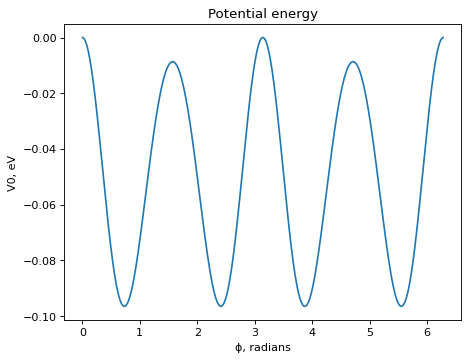

In [5]:
x = np.arange(phi_1, phi_2, 0.01)
plt.plot(x, potential(x) * KE_C)
plt.title("Potential energy")
plt.xlabel(r'ϕ, radians')
plt.ylabel(r'V0, eV')
plt.show()

In [6]:
# Define finite difference and amount of elements
N = 100000
phi = np.linspace(phi_1, phi_2, N)
dphi = np.diff(phi)[0]

In [7]:
# Define and solve tridiagonal matrix eigenvalue problem
main_diag = 2 * np.ones(N) / dphi**2 + potential(phi)
second_diag = -np.ones(N - 1) / dphi**2
energies, wave_funcs = eigh_tridiagonal(main_diag, 
                                        second_diag, 
                                        select='v', 
                                        select_range=(b_min, b_max))
wave_funcs = wave_funcs.T

In [8]:
# Calculate normalization constant for plotting wave functions 
# by summing all small psi parts
n_wavefuncs_to_plot = 8
normalizations_consts = []

# Integrate probability distribution functions to get coefficients
for i in range(0, min(n_wavefuncs_to_plot, len(wave_funcs))):
    const = np.sum(np.multiply(np.square(wave_funcs[i]), np.array(dphi)))
    normalizations_consts.append(const)
normalizations_consts = np.sqrt(normalizations_consts)

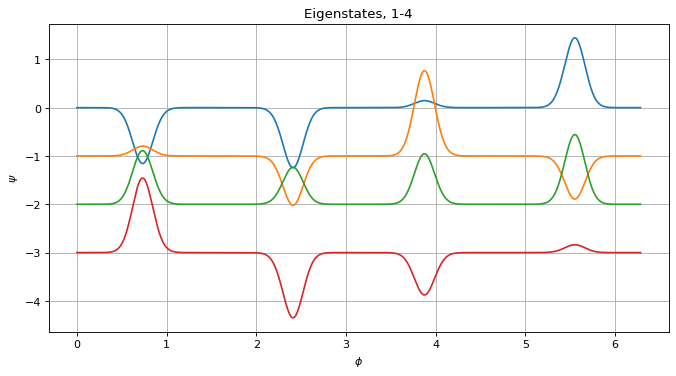

In [9]:
plt.figure(figsize=(10,5))
for i in range(0, min(5, len(wave_funcs)) - 1):
    plt.plot(phi, wave_funcs[i] / normalizations_consts[i] - np.ones(N) * i)
plt.title('Eigenstates, 1-4')
plt.ylabel('$\psi$')
plt.xlabel('$\phi$')
plt.grid()
plt.show()

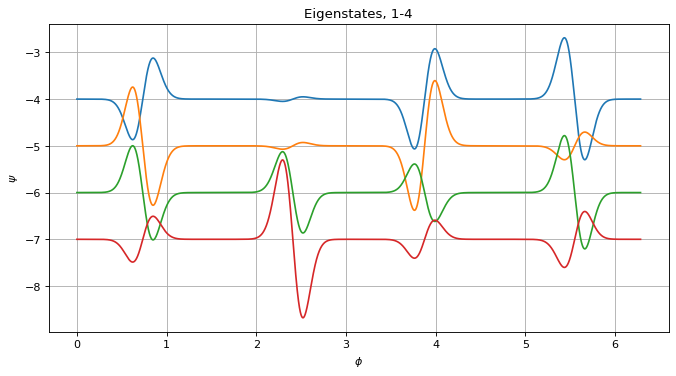

In [10]:
plt.figure(figsize=(10,5))
for i in range(4, 8):
    plt.plot(phi, wave_funcs[i] / normalizations_consts[i] - np.ones(N) * i)
plt.title('Eigenstates, 1-4')
plt.ylabel('$\psi$')
plt.xlabel('$\phi$')
plt.grid()
plt.show()

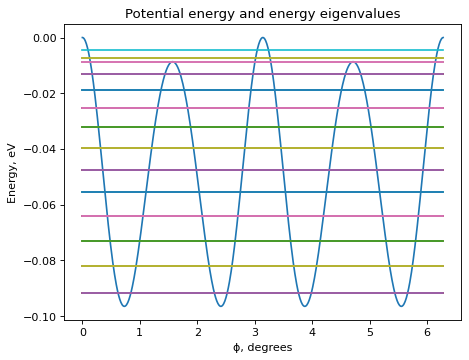

In [11]:
n_energies_to_plot = 50
x = np.arange(phi_1, phi_2, 0.01)
plt.plot(x, potential(x) * KE_C)
for i in range(0, min(n_energies_to_plot, len(energies)) - 1):
    plt.plot(x, np.ones(len(x)) * (energies[i] * KE_C))
plt.title("Potential energy and energy eigenvalues")
plt.xlabel(r'ϕ, degrees')
plt.ylabel(r'Energy, eV')
plt.show()

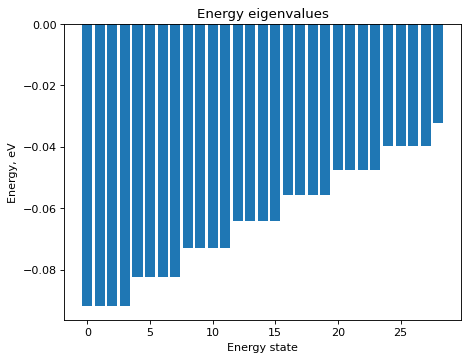

In [12]:
n_energies_to_plot = 30
plt.bar(np.arange(0, min(n_energies_to_plot, len(energies)) - 1, 1),
        energies[:min(n_energies_to_plot, len(energies)) - 1] * KE_C)
plt.title("Energy eigenvalues")
plt.xlabel(r'Energy state')
plt.ylabel(r'Energy, eV')
plt.show()

## Solution 2. Rewriting wave function in Fourier basis with sines and cosines
We rewrite our wave function in this form:
$$
\Psi(\phi)=\sum_{m=0}^{\infty} \left[ a_m\Phi_{mc}(\phi) + b_m\Phi_{ms}(\phi)\right],
$$
where 
$$
\Phi_{ms}(\phi)=\frac{1}{\sqrt{\pi}}\sin{m\phi}
$$ 
and  
$$
\Phi_{mc}(\phi)=\frac{1}{\sqrt{\pi}}\cos{m\phi}.
$$
As an approximation, we use m from 0 to M, where M is large.  

In [13]:
# Define amount of cosines and sines for fourier basis
M = 60

Hcos = np.zeros((M, M))
Hsin = np.zeros((M, M))

In [14]:
for m in tqdm(range(M)):
    for m_s in range(M):
        def integrand(phi):
            return 1 / np.pi * np.cos(phi * m) * (
                   m_s ** 2 * KE_C + potential(phi) * KE_C) * np.cos(phi * m_s)
        Hcos[m, m_s] = quad(integrand, phi_1, phi_2)[0]

  0%|          | 0/60 [00:00<?, ?it/s]

C:\Users\ArtDo\AppData\Local\Temp\ipykernel_16156\1147008417.py:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Hcos[m, m_s] = quad(integrand, phi_1, phi_2)[0]
C:\Users\ArtDo\AppData\Local\Temp\ipykernel_16156\1147008417.py:6: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  Hcos[m, m_s] = quad(integrand, phi_1, phi_2)[0]


In [15]:
for m in tqdm(range(M)):
    for m_s in range(M):
        def integrand(phi):
            return 1 / np.pi * np.sin(phi * m) * (
                   m_s ** 2 * KE_C + potential(phi) * KE_C) * np.sin(phi * m_s)
        Hsin[m, m_s] = quad(integrand, phi_1, phi_2)[0]

  0%|          | 0/60 [00:00<?, ?it/s]

C:\Users\ArtDo\AppData\Local\Temp\ipykernel_16156\1593180616.py:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Hsin[m, m_s] = quad(integrand, phi_1, phi_2)[0]
C:\Users\ArtDo\AppData\Local\Temp\ipykernel_16156\1593180616.py:6: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  Hsin[m, m_s] = quad(integrand, phi_1, phi_2)[0]


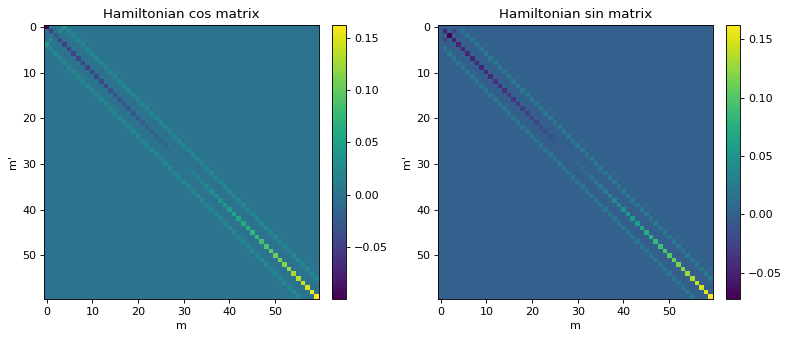

In [16]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))
fig.tight_layout()

im1 = axes[0].imshow(Hcos)
axes[0].set_title("Hamiltonian cos matrix")
axes[0].set_xlabel(r'm')
axes[0].set_ylabel(r"m'")
cbar = axes[0].figure.colorbar(im1, ax = axes[0], fraction=0.046, pad=0.04)

im2 = axes[1].imshow(Hsin)
axes[1].set_title("Hamiltonian sin matrix")
axes[1].set_xlabel(r'm')
axes[1].set_ylabel(r"m'")
cbar = axes[1].figure.colorbar(im2, ax = axes[1], fraction=0.046, pad=0.04)

In [17]:
# energies_sin, wf_coefficients_sin = LA.eig(Hsin)
# energies_cos, wf_coefficients_cos = LA.eig(Hcos)

In [18]:
energies, wf_coefficients = LA.eig(Hcos)

In [19]:
new_indexes = np.argsort(energies)
sorted_energies = energies[new_indexes]
sorted_wf_coefficients = wf_coefficients[new_indexes]
print(new_indexes[:5])

[ 0 14 16 19 15]


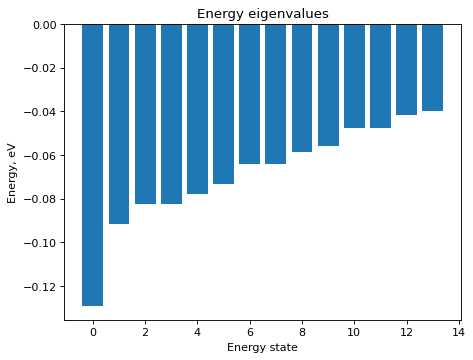

In [20]:
n_energies_to_plot = 15
plt.bar(np.arange(0, min(n_energies_to_plot, len(energies)) - 1, 1), 
        sorted_energies[:min(n_energies_to_plot, len(energies)) - 1])
plt.title("Energy eigenvalues")
plt.xlabel(r'Energy state')
plt.ylabel(r'Energy, eV')
plt.show()

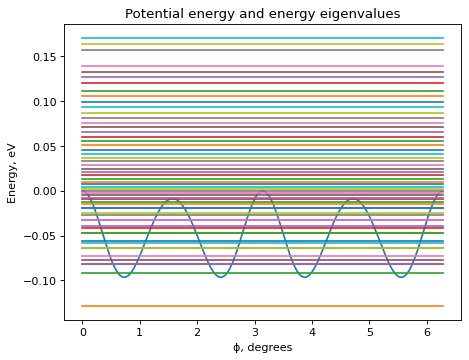

In [21]:
n_energies_to_plot = 60
x = np.arange(phi_1, phi_2, 0.01)
plt.plot(x, potential(x) * KE_C)
for i in range(0, min(n_energies_to_plot, len(energies)) - 1):
    plt.plot(x, np.ones(len(x)) * (sorted_energies[i]))
plt.title("Potential energy and energy eigenvalues")
plt.xlabel(r'ϕ, degrees')
plt.ylabel(r'Energy, eV')
plt.show()

In [22]:
# Calculate normalization constant for plotting wave functions 
# by integrating |psi|^2
n_wavefuncs_to_plot = 8
normalizations_consts = []

# Define wave function as sum
def psi(phi, C):
    res = 0
    for m, coef in enumerate(C):
        res += coef * np.cos(m * phi) + coef * np.sin(m * phi)
    return res

def probability_psi(phi, C):
    return abs(psi(phi, C)) ** 2

# Integrate probability distribution functions to get coefficients
for i in range(0, min(n_wavefuncs_to_plot, len(sorted_wf_coefficients))):
    normalizations_consts.append(quad(probability_psi, phi_1, phi_2, args=sorted_wf_coefficients[i])[0])

C:\Users\ArtDo\AppData\Local\Temp\ipykernel_16156\1197494094.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  normalizations_consts.append(quad(probability_psi, phi_1, phi_2, args=sorted_wf_coefficients[i])[0])


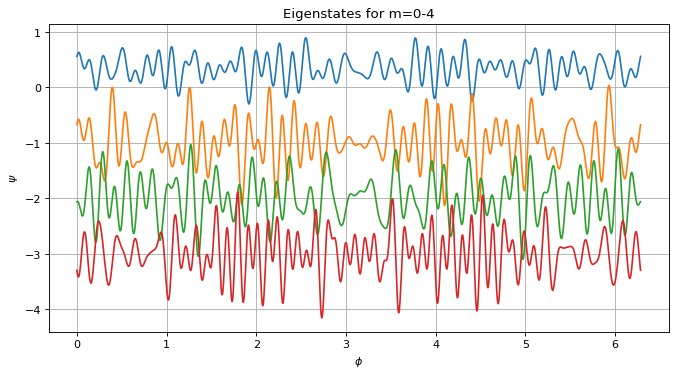

In [23]:
# Plot wave functions
phi = np.linspace(phi_1, phi_2, N)
plt.figure(figsize=(10,5))
for i in range(0, (min(n_wavefuncs_to_plot, len(sorted_wf_coefficients)))//2):
    plt.plot(phi, psi(phi, sorted_wf_coefficients[i]) / 
             np.sqrt(normalizations_consts[i]) - np.ones(N) * i)
plt.title('Eigenstates for m=0-4')
plt.ylabel('$\psi$')
plt.xlabel('$\phi$')
plt.grid()
plt.show()

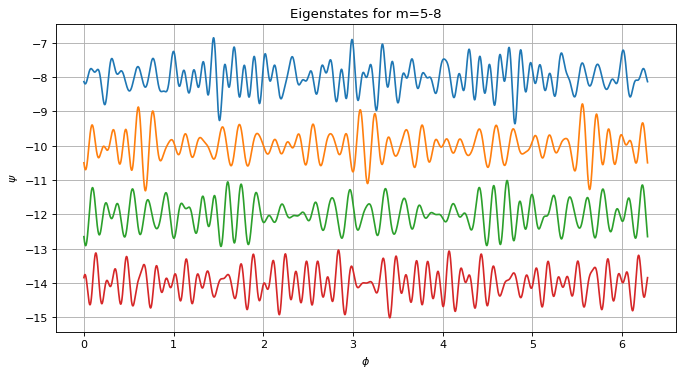

In [24]:
# Plot wave functions
phi = np.linspace(phi_1, phi_2, N)
plt.figure(figsize=(10,5))
for i in range((min(n_wavefuncs_to_plot, len(sorted_wf_coefficients)))//2, 
               (min(n_wavefuncs_to_plot, len(sorted_wf_coefficients)))):
    plt.plot(phi, psi(phi, sorted_wf_coefficients[i]) / 
             np.sqrt(normalizations_consts[i]) - np.ones(N) * i * 2)
plt.title('Eigenstates for m=5-8')
plt.ylabel('$\psi$')
plt.xlabel('$\phi$')
plt.grid()
plt.show()

## Solution 2. Rewriting wave function in Fourier basis with exponents
We rewrite our wave function in this form:
$$
\Psi(\phi)=\sum_{m=-\infty}^{\infty} c_m\Phi_m(\phi),
$$
where 
$$
\Phi_m(\phi)=\frac{1}{\sqrt{2\pi}}e^{im\phi}
$$
As an approximation, we use m from -M to +M, where M is large.

In [25]:
# Define amount of exponents for fourier basis
# Make bigger to get higher accuracy (runs slower)
M = 60

In [26]:
H = np.zeros((M, M))

# Calculate Hamiltonian matrix
for m in tqdm(range(M)):
    for m_s in range(M):
        def integrand(phi):
            return 1 / 2 / np.pi * np.cos(phi * (m_s - m)) * (
                   (m_s - M / 2) ** 2 * KE_C + potential(phi) * KE_C)
        H[m, m_s] = quad(integrand, phi_1, phi_2)[0]

  0%|          | 0/60 [00:00<?, ?it/s]

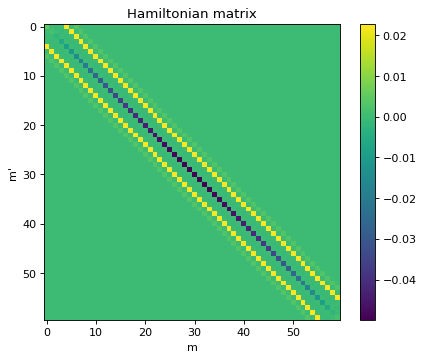

In [27]:
fig, ax = plt.subplots()
im = ax.imshow(H)
ax.set_title("Hamiltonian matrix")
ax.set_xlabel(r'm')
ax.set_ylabel(r"m'")
cbar = ax.figure.colorbar(im, ax = ax)

In [28]:
# Solve eigenvalue problem
energies, wf_coefficients = LA.eig(H)

In [29]:
# Sort the energies and wave function coefficients, from smallest energy to biggest
new_indexes = np.argsort(energies)
sorted_energies = energies[new_indexes]
sorted_wf_coefficients = wf_coefficients.T[new_indexes]
print(new_indexes[:5])

[ 6  8  7  5 11]


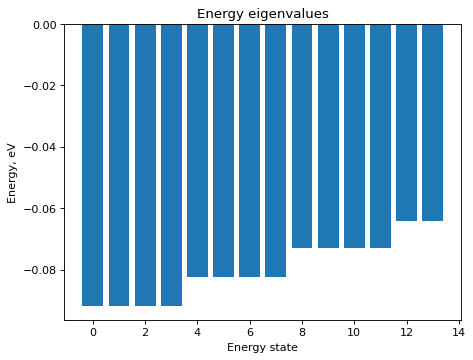

In [30]:
n_energies_to_plot = 15
plt.bar(np.arange(0, min(n_energies_to_plot, len(energies)) - 1, 1), 
        sorted_energies[:min(n_energies_to_plot, len(energies)) - 1])
plt.title("Energy eigenvalues")
plt.xlabel(r'Energy state')
plt.ylabel(r'Energy, eV')
plt.show()

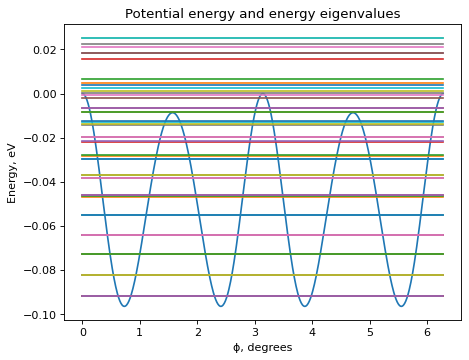

In [31]:
n_energies_to_plot = 60
x = np.arange(phi_1, phi_2, 0.01)
plt.plot(x, potential(x) * KE_C)
for i in range(0, min(n_energies_to_plot, len(energies)) - 1):
    plt.plot(x, np.ones(len(x)) * (sorted_energies[i]))
plt.title("Potential energy and energy eigenvalues")
plt.xlabel(r'ϕ, degrees')
plt.ylabel(r'Energy, eV')
plt.show()

In [32]:
# Calculate normalization constant for plotting wave functions 
# by integrating |psi|^2
n_wavefuncs_to_plot = 8
normalizations_consts = []

# Define wave function as sum
def psi(phi, C):
    res = 0
    for m, coef in enumerate(C):
        res += coef * np.cos((m - M / 2) * phi) # cos is the real part of e^ix
    return res

def probability_psi(phi, C):
    return abs(psi(phi, C)) ** 2

# Integrate probability distribution functions to get coefficients
for i in range(0, min(n_wavefuncs_to_plot, len(sorted_wf_coefficients))):
    normalizations_consts.append(quad(probability_psi, phi_1, phi_2, args=sorted_wf_coefficients[i])[0])

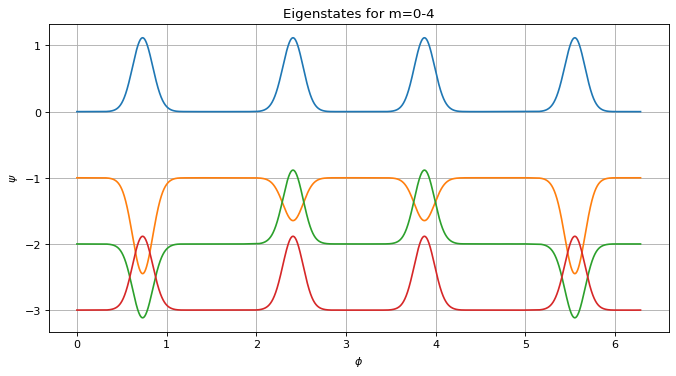

In [33]:
# Plot wave functions
phi = np.linspace(phi_1, phi_2, N)
plt.figure(figsize=(10,5))
for i in range(0, (min(n_wavefuncs_to_plot, len(sorted_wf_coefficients)))//2):
    plt.plot(phi, psi(phi, sorted_wf_coefficients[i]) / 
             np.sqrt(normalizations_consts[i]) - np.ones(N) * i)
plt.title('Eigenstates for m=0-4')
plt.ylabel('$\psi$')
plt.xlabel('$\phi$')
plt.grid()
plt.show()

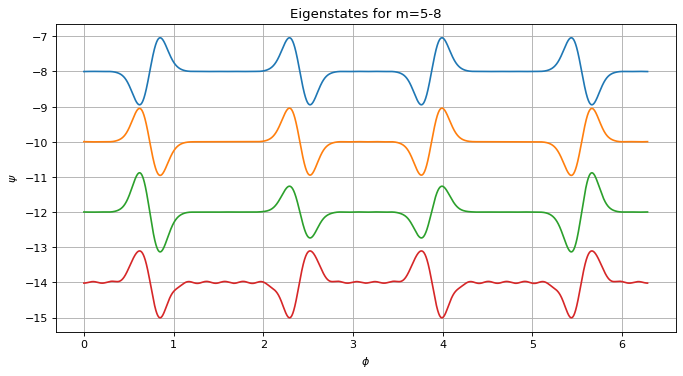

In [34]:
# Plot wave functions
phi = np.linspace(phi_1, phi_2, N)
plt.figure(figsize=(10,5))
for i in range((min(n_wavefuncs_to_plot, len(sorted_wf_coefficients)))//2, 
               (min(n_wavefuncs_to_plot, len(sorted_wf_coefficients)))):
    plt.plot(phi, psi(phi, sorted_wf_coefficients[i]) / 
             np.sqrt(normalizations_consts[i]) - np.ones(N) * i * 2)
plt.title('Eigenstates for m=5-8')
plt.ylabel('$\psi$')
plt.xlabel('$\phi$')
plt.grid()
plt.show()